<center>
<h1>Visualización en tiempo real de ocupación de espacios en Campus San Joaquín mediante sistema de Edge Computing con LoRa</h1>


José Miguel Quezada Silva

Universidad Técnica Federico Santa María

2022
</center>

# Contextualización

**Problema**: Uso ineficiente de espacios físicos en Campus San Joaquín UTFSM

**Conceptos**:
*   *Crowd Counting*
*   *Computer Vision* (*Deep Learning*)
*   *LoRa* + *Edge Computing*

**Propuesta de solución**:

Sistema compuesto por una red de computación *Edge* basada en el uso de *LoRa* para transmitir los resultados de una aplicación de *Crowd Counting* o, en otras palabras, la detección de ocupación de zonas mediante *Machine Learning* y *Computer Vision*.

# Introducción

En este programa se desarrolla los modelos de Crowd Counting a partir de la librería Keras, especializada en Machine Learning...

Modelo FOMO, de Edge Impulse, que utiliza la arquitectura base del modelo preentrenado MobileNetV2.

# Desarrollo

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf

import keras.backend as KB
# from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers import Dense,MaxPooling2D, BatchNormalization, Conv2D, Softmax, Input, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping

from PIL import Image
import matplotlib.patches as patches
# from scipy.ndimage import gaussian_filter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# http://www.crowd-counting.com/#download (JHU-CROWD++)
!cp -r /content/drive/My\ Drive/Titulo/jhu_crowd_v2.0.zip ./jhu_crowd_v2.0.zip

!unzip -oq jhu_crowd_v2.0.zip

## README JHU-CROWD++

In [ ]:
'''
Each of these contain 2 sub-directories (images, gt) and a file "image_labels.txt".

3. The "images" directory contains images and the "gt" directory contains ground-truth files
   corresponding to the images in the images directory.

4. The number of samples in train, val and test split are 2272, 500, 1600 respectively.
-----------------------------------------------------------------------------------------------------
GROUND-TRUTH ANNOTATIONS: "HEAD-LEVEL"
-----------------------------------------------------------------------------------------------------
1. Each ground-truth file in the "gt" directory contains "space" separated values with each row
   inidacting x,y,w,h,o,b

2. x,y indicate the head locat  ion.

3. w,h indicate approximate width and height of the head.

4. o indicates occlusion-level and it can take 3 possible values: 1,2,3.
   o=1 indicates "visible"
   o=2 indicates "partial-occlusion"
   o=3 indicates "full-occlusion"

5. b indicates blur-level and it can take 2 possible values: 0,1.
   b=0 indicates no-blur
   b=1 indicates blur

-----------------------------------------------------------------------------------------------------
GROUND-TRUTH ANNOTATIONS: "IMAGE-LEVEL"
-----------------------------------------------------------------------------------------------------
1. Each split in the dataset contains a file "image_labels.txt". This file contains image-level labels.

2. The values in the file are comma separated and each row indicates:
	"filename, total-count, scene-type, weather-condition, distractor"

3. total-count indicates the total number of people in the image

4. scene-type is an image-level label describing the scene

5. weather-condition indicates the weather-degradation in the image and can take 4 values: 0,1,2,3
   weather-condition=0 indicates "no weather degradation"
   weather-condition=1 indicates "fog/haze"
   weather-condition=2 indicates "rain"
   weather-condition=3 indicates "snow"

6. distractor indicates if the image is a distractor. It can take 2 values: 0,1
   distractor=0 indicates "not a distractor"
   distractor=1 indicates "distractor"
'''

## Preprocesamiento de datos

A partir del dataset público [JHU-CROWD++](https://www.crowdhuman.org/), se cuenta con imágenes con distintas densidades de personas, junto con sus respectivas etiquetas, que indican tanto la cantidad de individuos, como la ubicación exacta de cada cabeza.

In [ ]:
# demostración de imágenes con labels

### Lectura de archivos

In [ ]:
# convertir texto a df
# etapa: train, val o test
def txt_df(arch, etapa, col_index, col_names, sep):
    return pd.read_csv('jhu_crowd_v2.0/' + etapa +'/'+ arch + ".txt",
                      usecols=col_index,
                      names=col_names,
                      delimiter = sep,
                      engine="python")

In [ ]:
train = txt_df("image_labels", "train", [0,1], ["id", "count"], "\n|,")
val = txt_df("image_labels", "val", [0,1], ["id", "count"], "\n|,")
test = txt_df("image_labels", "test", [0,1], ["id", "count"], "\n|,")

In [ ]:
train.head()

id  count
0   1    161
1   8    855
2  10    455
3  12   7139
4  14    111

### Obtener dimensiones de imágenes

In [ ]:
# retorna [id, height, width] de una imagen
def get_dims(ubicacion, img_name, is_jhu_dataset=True):

    # formatear nombre de archivo
    if is_jhu_dataset:
        fmt_img_name = f"{img_name:04d}"
    else:
        fmt_img_name = img_name

    return np.array([img_name] + list(img_to_array(load_img(ubicacion + fmt_img_name + ".jpg")).shape[:2]))

get_dims_vec = np.vectorize(get_dims, otypes=[np.ndarray])

In [ ]:
# obtener dimensiones de cada imagen y almacenar en arreglo correspondiente
def dim_imgs(ubicacion, df):

    dims = get_dims_vec(ubicacion, df["id"])
    dims = np.array([x for x in dims])
    dims = pd.DataFrame(dims, columns=["id", "height", "width"])

    # unir dimensiones
    df_merge = df.merge(dims,on="id")
    arr_merge = df_merge.values
    return arr_merge

In [ ]:
# output: array [id, count, height, width]
train_count_dims = dim_imgs("jhu_crowd_v2.0/train/images/", train)
val_count_dims = dim_imgs("jhu_crowd_v2.0/val/images/", val)
test_count_dims = dim_imgs("jhu_crowd_v2.0/test/images/", test)

In [ ]:
# Almacenar datos en archivos
np.save('/content/drive/My Drive/Titulo/img_data/train_count_dims.npy', train_count_dims)
np.save('/content/drive/My Drive/Titulo/img_data/val_count_dims.npy', val_count_dims)
np.save('/content/drive/My Drive/Titulo/img_data/test_count_dims.npy', test_count_dims)

In [ ]:
# Cargar npy a df
def load_np_df(npy_name, cols):

    data = np.load('/content/drive/My Drive/Titulo/img_data/' + npy_name + '.npy',allow_pickle=True)
    data = pd.DataFrame(data, columns=cols)

    return data

In [ ]:
# volver a cargar datasets, con dimensiones originales de cada imagen
data_cols = ["id", "count", "height", "width"]
train_data = load_np_df("train_count_dims", data_cols)
val_data = load_np_df("val_count_dims", data_cols)
test_data = load_np_df("test_count_dims", data_cols)

### Filtrar datos

In [ ]:
# 27/1/23 18:03
64
98
99

# 30/3/23 17:34
99
98
64
# cuadrados de colores - pagina web

In [ ]:
# sin filtrar
train_data["count"].describe()

count     2272.000000
mean       371.761444
std       1129.511843
min          0.000000
25%         45.000000
50%        111.000000
75%        279.000000
max      25791.000000
Name: count, dtype: float64

In [ ]:
# Filtrar datos

# train
train.query("count < 80", inplace=True)
train.reset_index(inplace=True)
train.drop("index", axis=1, inplace=True)

# val
val.query("count < 80", inplace=True)
val.reset_index(inplace=True)
val.drop("index", axis=1, inplace=True)

# test
test.query("count < 80", inplace=True)
test.reset_index(inplace=True)
test.drop("index", axis=1, inplace=True)

In [ ]:
# Filtrar datos

# train
train_data.query("count < 80", inplace=True)
train_data.reset_index(inplace=True)
train_data.drop("index", axis=1, inplace=True)

# val
val_data.query("count < 80", inplace=True)
val_data.reset_index(inplace=True)
val_data.drop("index", axis=1, inplace=True)

# test
test_data.query("count < 80", inplace=True)
test_data.reset_index(inplace=True)
test_data.drop("index", axis=1, inplace=True)

In [ ]:
# count < 500
train_data["count"].describe()

count    927.000000
mean      38.449838
std       20.477755
min        0.000000
25%       21.000000
50%       38.000000
75%       55.000000
max       79.000000
Name: count, dtype: float64

In [ ]:
# count < 80
train_data["count"].describe()

count    927.000000
mean      38.449838
std       20.477755
min        0.000000
25%       21.000000
50%       38.000000
75%       55.000000
max       79.000000
Name: count, dtype: float64

In [ ]:
val_data["count"].describe()

count    228.000000
mean      36.403509
std       20.470122
min        2.000000
25%       19.750000
50%       33.500000
75%       51.000000
max       79.000000
Name: count, dtype: float64

In [ ]:
val["count"].describe()

count    257.000000
mean      42.330739
std       25.546594
min        2.000000
25%       21.000000
50%       39.000000
75%       62.000000
max       99.000000
Name: count, dtype: float64

In [ ]:
test_data["count"].describe()

count    638.000000
mean      37.948276
std       21.151739
min        0.000000
25%       20.000000
50%       37.000000
75%       55.000000
max       79.000000
Name: count, dtype: float64

### Guardar listas de imágenes (borrar)

In [ ]:
train_ids = [x for x in map(lambda x: f"{x:04d}" + '.jpg', train.id.values)]
val_ids = [x for x in map(lambda x: f"{x:04d}" + '.jpg', val.id.values)]
test_ids = [x for x in map(lambda x: f"{x:04d}" + '.jpg', test.id.values)]

In [ ]:
np.savetxt('train_ei.txt', train_ids, fmt="%s")
np.savetxt('val_ei.txt', val_ids, fmt="%s")
np.savetxt('test_ei.txt', test_ids, fmt="%s")

### Frecuencia de cantidades de personas

In [ ]:
def plotFreq(col, label):
    data, frecuencia = np.unique(col, return_counts=True)

    fig, ax = plt.subplots(figsize=(20,5),nrows=1)
    p = sns.barplot(x=data, y=frecuencia, palette="rocket",ax=ax)

    # titular cada eje
    # agrandar titulo
    ax.set_title(label)
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        # eje x en intervalos de 5
        if n % 5 != 0:
            label.set_visible(False)
        # plt.xticks(rotation=90)

    plt.show()

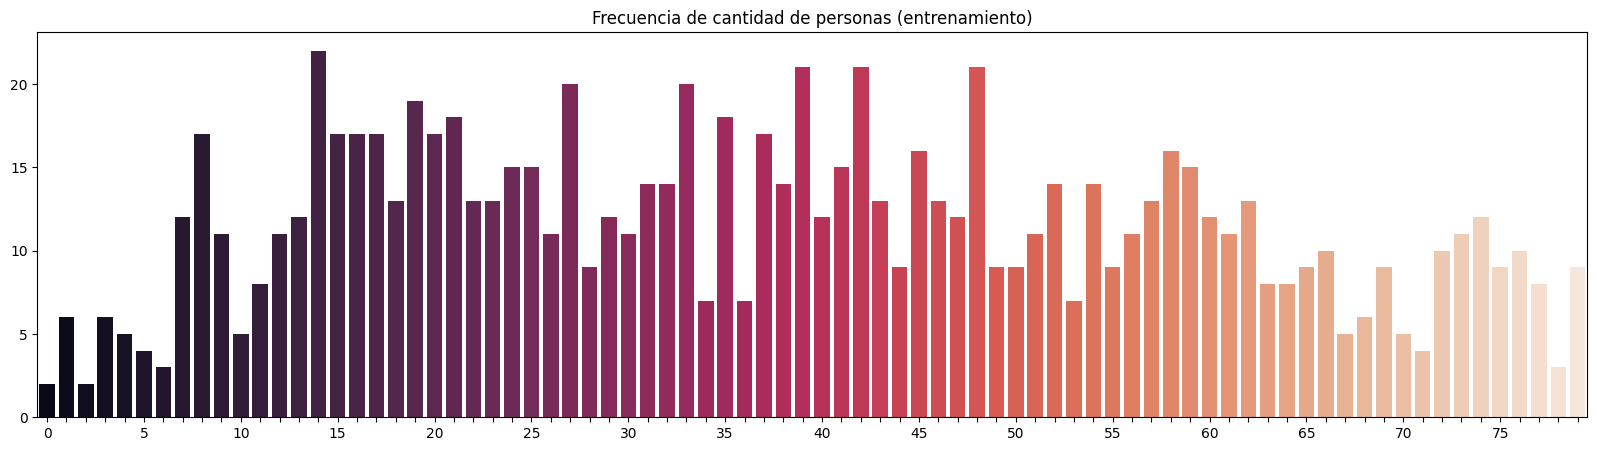

In [ ]:
plotFreq(train_data['count'], "Frecuencia de cantidad de personas (entrenamiento)")

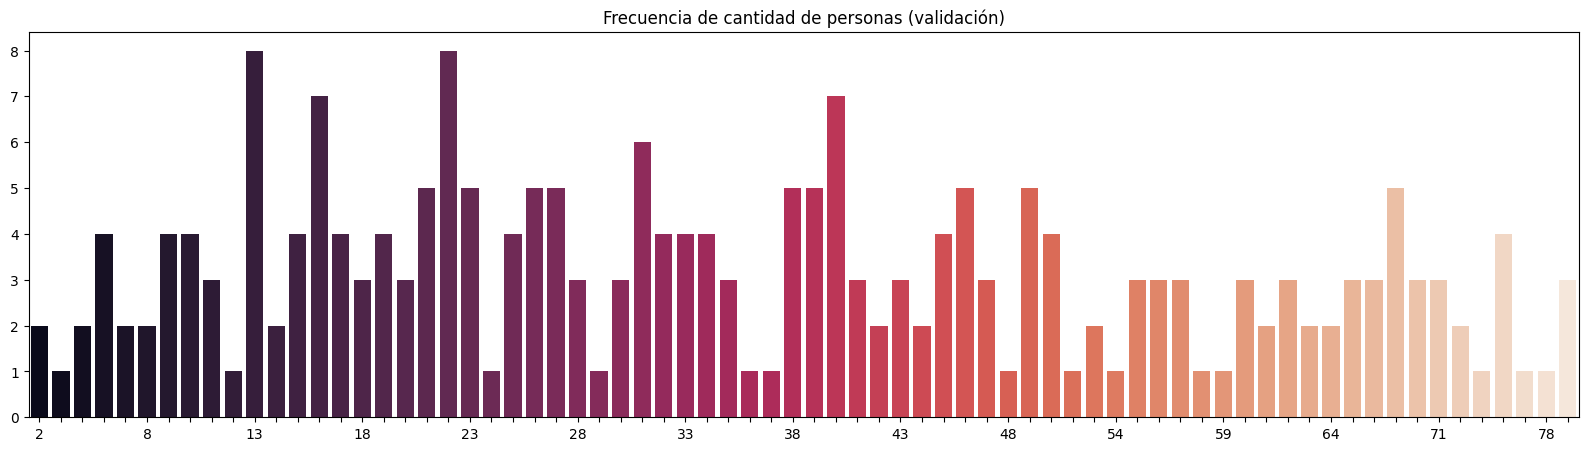

In [ ]:
plotFreq(val_data['count'], "Frecuencia de cantidad de personas (validación)")

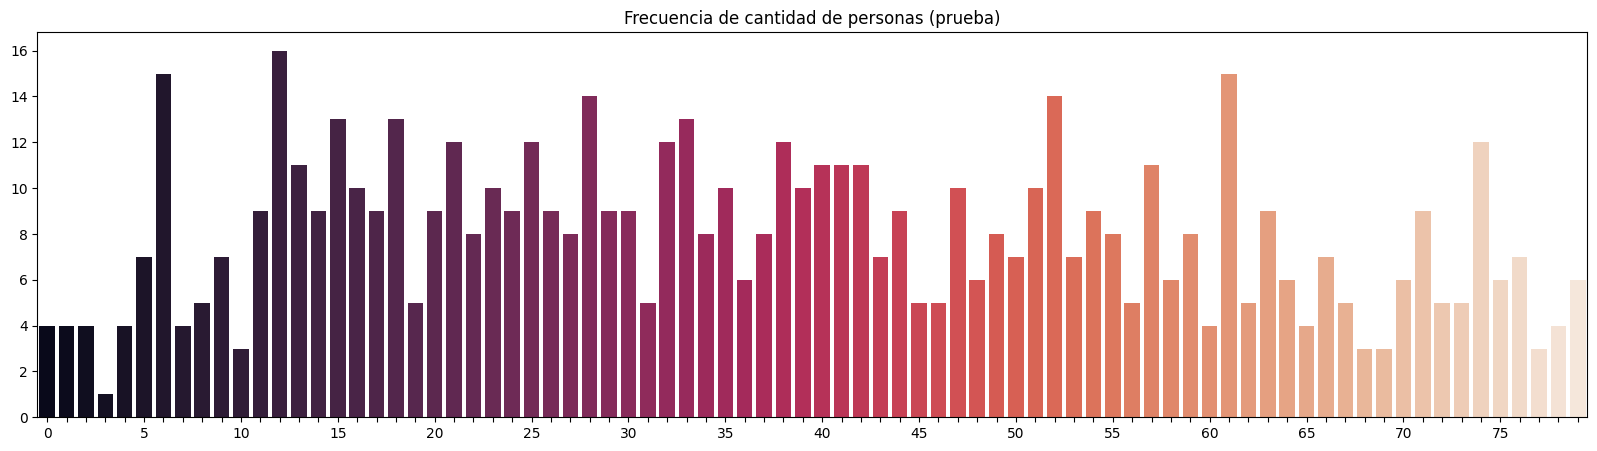

In [ ]:
plotFreq(test_data['count'], "Frecuencia de cantidad de personas (prueba)")

In [ ]:
!cat jhu_crowd_v2.0/train/gt/0001.txt

106 114 24 25 1 0
705 79 19 21 1 0
661 361 30 37 1 0
212 332 30 37 1 0
704 236 20 25 1 0
620 404 30 37 1 0
615 248 20 25 1 0
641 165 20 25 1 0
676 47 19 21 1 0
422 29 19 21 1 0
71 48 19 21 1 0
107 62 19 21 1 0
76 85 19 21 1 0
692 37 19 21 1 0
251 221 20 25 1 0
535 44 19 21 1 0
528 93 19 21 1 0
36 46 19 21 1 0
240 44 19 21 1 0
467 115 24 25 1 0
497 79 19 21 1 0
484 204 20 25 1 0
342 136 24 25 1 0
326 152 24 25 1 0
404 379 30 37 1 0
469 229 20 25 1 0
267 57 19 21 1 0
447 56 19 21 1 0
411 296 20 25 1 0
102 195 20 25 1 0
43 394 30 37 1 0
179 65 19 21 1 0
675 27 19 21 1 0
640 76 19 21 1 0
295 49 19 21 1 0
170 133 24 25 1 0
275 18 19 21 1 0
624 479 30 37 1 0
338 82 19 21 1 0
510 170 20 25 1 0
386 226 20 25 1 0
118 411 30 37 1 0
137 255 20 25 1 0
608 62 19 21 1 0
551 168 20 25 1 0
207 55 19 21 1 0
62 16 19 21 1 0
590 283 20 25 1 0
577 35 19 21 1 0
357 104 19 21 1 0
229 426 30 37 1 0
331 210 20 25 1 0
485 59 19 21 1 0
189 292 20 25 1 0
277 334 30 37 1 0
410 203 20 25 1 0
53 61 19 21 1 0
535 13

### Abrir imágenes

In [ ]:
# dimensiones de imagenes
# al parecer deben ser cuadradas
width = 224
height = 149

# https://stackoverflow.com/questions/44231209/resize-rectangular-image-to-square-keeping-ratio-and-fill-background-with-black
def make_square(im, min_size=224, fill_color=0):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('L', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

# convertir imagen a arreglo np
def readImg(img_name, square=True):
    # agregar marcos negros para mantener relación de aspecto
    img = load_img(img_name,
                    target_size=(height,width),
                    color_mode='grayscale')
    if square:
        img = make_square(img)

    return img_to_array(img)

# leer imagenes de JHU-Crowd++
# etapa: train, val o test
def readJHUImg(img_name, etapa):
    return readImg('jhu_crowd_v2.0/'+str(etapa)+'/images/' + f"{img_name:04d}" + '.jpg')

# triplicar los canales de una imagen, en caso de haber sido cargada en grayscale
def tripleLayerImg(img_arr):
    # grey_image_arr = np.expand_dims(img_arr, -1)
    if len(img_arr.shape) == 2:
        img_arr = np.expand_dims(img_arr, -1)
    return img_arr.repeat(3, axis=-1).astype(int)


# función vectorizada
readImg_vec = np.vectorize(readImg, otypes=[np.ndarray])
readJHUImg_vec = np.vectorize(readJHUImg, otypes=[np.ndarray])
tripleLayer_vec = np.vectorize(tripleLayerImg, otypes=[np.ndarray])

In [ ]:
# no se pueden cargar todas las imágenes, hay que usar generadores

X_train = readJHUImg_vec(train_data.id, "train")
X_train = np.array([np.array(x) for x in X_train])
# X_train = X_train.astype('float32') / 255
X_train = tripleLayer_vec(X_train)

X_val = readJHUImg_vec(val_data.id, "val")
X_val = np.array([np.array(x) for x in X_val])
# X_val = X_val.astype('float32') / 255
X_val = tripleLayer_vec(X_val)

X_test = readJHUImg_vec(test_data.id, "test")
X_test = np.array([np.array(x) for x in X_test])
# X_test = X_test.astype('float32') / 255
X_test = tripleLayer_vec(X_test)

print("Dimensiones entrenamiento:", X_train.shape)
print("Dimensiones validación:", X_val.shape)
print("Dimensiones test:", X_test.shape)

### Dataset LDS

In [ ]:
from json import loads

lds_dataset_loc = "/content/drive/My Drive/Titulo/Dataset LDS/"
gt_lds = pd.read_csv(lds_dataset_loc + "vialabels.csv")

# convertir coordenadas a json
gt_lds.region_shape_attributes = list(map(loads, gt_lds.region_shape_attributes))

# en este caso x,y es la esquina superior izquierda del label
# coords["x"], coords["y"], coords["width"], coords["height"]

# eliminar atributo 'name' de conjunto de coordenadas
def pop_name(json_item):
    if len(json_item) > 0:
        try:
            json_item.pop('name')
        except:
            pass

# se vectoriza y aplica
np.vectorize(pop_name, otypes=[np.ndarray]) (gt_lds.region_shape_attributes)

# al parecer es ligeramente más eficiente usar lambda que def
# (https://stackoverflow.com/questions/134626/which-is-more-preferable-to-use-lambda-functions-or-nested-functions-def)
gt_lds.region_shape_attributes = np.vectorize(lambda x: list(x.values()),
                                              otypes=[np.ndarray]) \
                                (gt_lds.region_shape_attributes)

# se crea el nuevo dataframe con las coordenadas separadas en columnas
gt_lds = gt_lds[['filename']].join(pd.DataFrame(gt_lds.region_shape_attributes.to_list(),
                                                columns=['x','y','width','height']).astype('Int64'))

print(gt_lds)

        filename    x    y  width  height
0     lds000.jpg  216   94     12      14
1     lds000.jpg  304   58      7       7
2     lds000.jpg  168   80      6       8
3     lds001.jpg  246  143     25      30
4     lds001.jpg  135   85      8      10
..           ...  ...  ...    ...     ...
197  lds0044.jpg  258   88     13      16
198  lds0044.jpg  255  107     24      28
199  lds0044.jpg  266   68      8       8
200  lds0044.jpg  268   74      8       9
201  lds0044.jpg  160   73     12      13

[202 rows x 5 columns]


In [ ]:
# dimensiones de lds000.jpg
lds_img_dim = get_dims(lds_dataset_loc, "lds000", is_jhu_dataset=False)[1:].astype(int)

In [ ]:
group_values = [] # datos de cada imagen
gtlds_dic = {}    # diccionario con ground-truth
prev_fn = ""      # filename previo

# fn: filename, g: group
for fn, g in gt_lds.groupby('filename'):

    if fn != prev_fn and prev_fn != "":

        # ajustar coordenadas a tamaño de imagen a utilizar
        group_values = fix_bbox_info(np.array(group_values),
                                     width, height,
                                     lds_img_dim[1], lds_img_dim[0],
                                     is_jhu_dataset = False)

        # se guarda el arreglo en el diccionario
        gtlds_dic[prev_fn] = np.array(group_values)
        # print(gtlds_dic[prev_fn])

        group_values = []

    # dejar arreglo vacio si no hay bounding boxes
    if g[['x', 'y', 'width', 'height']].isnull().values.any():
        prev_fn = fn
        continue

    # se extraen los datos de los bounding boxes
    # se requiere una columna extra al comienzo para fix_bbox_info
    group_values = g[['x', 'y', 'width', 'height']].values.astype(int)

    prev_fn = fn

# último grupo
gtlds_dic[fn] = np.array(group_values)

print(gtlds_dic)

{'lds000.jpg': array([[162,  94,   9,  14],
       [228,  58,   5,   7],
       [126,  80,   4,   8]]), 'lds001.jpg': array([[184, 143,  18,  30],
       [101,  85,   6,  10],
       [ 39,  89,   6,   8],
       [196,  93,   7,  12],
       [119,  83,   6,   8]]), 'lds0012.jpg': array([[ 73, 104,  24,  32]]), 'lds0013.jpg': array([[ 64, 116,  25,  36]]), 'lds0014.jpg': array([[111,  72,  24,  32]]), 'lds0015.jpg': array([], dtype=float64), 'lds0016.jpg': array([], dtype=float64), 'lds0017.jpg': array([[ 60, 119,  22,  33]]), 'lds0018.jpg': array([[167, 114,   9,  10],
       [143,  97,   5,   7],
       [134,  97,   4,   8],
       [ 58,  97,   5,   7],
       [ 47,  95,   5,   8],
       [117, 108,   5,   7]]), 'lds0019.jpg': array([[ 84,  78,   4,   6],
       [ 88,  76,   4,   6],
       [ 98,  85,   6,   8],
       [116,  94,   9,  12],
       [ 63,  88,   6,   8]]), 'lds002.jpg': array([[ 33, 145,  15,  20],
       [ 30, 163,  17,  23],
       [ 10, 126,   9,  11],
       [  6, 13

#### Data Augmentation

In [ ]:
%cd /content/drive/My\ Drive/Titulo/DataAugmentationForObjectDetection/
import data_aug.data_aug as data_aug
import data_aug.bbox_util as bbox_util

# este repositorio considera las coordenadas iniciales y finales,
# en vez de las iniciales y ancho y largo de la imagen, como en este trabajo...

# lo mas simple seria adaptar mi codigo a ese formato
# pero me parece que no es lo correcto, así que podría solo hacer la conversion
# en cada una de las clases del repo.

/content/drive/My Drive/Titulo/DataAugmentationForObjectDetection


In [ ]:
filename_or = list(gtlds_dic.keys())[0]
bboxes_or = gtlds_dic[filename_or]
img_or = readImg(lds_dataset_loc + filename_or)

In [ ]:
img_da, bboxes_da = data_aug.RandomHorizontalFlip(1)(img_or, bboxes_or.copy())

In [ ]:
bboxes_or

array([[162,  94,   9,  14],
       [228,  58,   5,   7],
       [126,  80,   4,   8]])

In [ ]:
bboxes_da

array([[ 69,  94,   9,  14],
       [  7,  58,   5,   7],
       [110,  80,   4,   8]])

In [ ]:
def plot_da(img_or, bboxes_or, img_da, bboxes_da):
    fig,ax = plt.subplots(1,2,figsize=(10,3))

    ax[0].imshow(img_or, cmap="gray")
    for x,y,w,h in bboxes_or:
        ax[0].add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', fill=None))

    ax[1].imshow(img_da, cmap="gray")
    for x,y,w,h in bboxes_da:
        ax[1].add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', fill=None))

    plt.show()

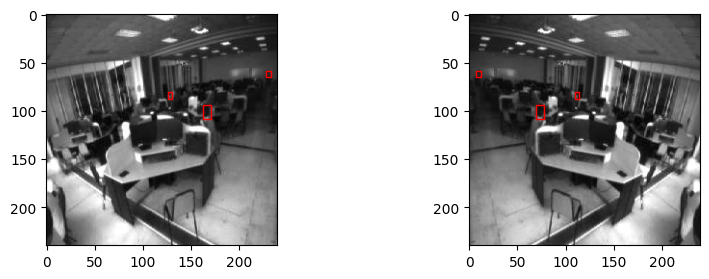

In [ ]:
plot_da(img_or, bboxes_or, img_da, bboxes_da)

In [ ]:
transf = [data_aug.HorizontalFlip,
            data_aug.Scale,
            data_aug.Translate,
            data_aug.Rotate,
            data_aug.Shear]

# generar secuencias aleatorias de transformaciones
# podría insertar cada método a un arreglo, y luego llamarlos despues de crear una secuencia numerica random
import random

def img_random_transf(img, bbox, n_max_transf = 3):

    # escoger aleatoriamente secuencia de hasta 3 transformaciones
    len_seq = random.choices(range(1, n_max_transf + 1))[0] #weights=None)
    rand_seq_idx = random.sample(list(range(5)), len_seq)

    img_t = img.copy()
    bboxes_t = bbox.copy()

    # rand_seq = data_aug.Sequence([i for i in transf[rand_seq_idx]])
    # agregar a secuencia
    print("randomly generated sequence: ", [transf[t] for t in rand_seq_idx])
    for t in rand_seq_idx:
        # rand_seq.append(transf[t])
        img_t, bboxes_t = transf[t]()(img_t, bboxes_t)


    # img_t, bbox_t = rand_seq(img_t, bboxes_t)
    return (img_t, bboxes_t)

In [ ]:
filename_ex = list(gtlds_dic.keys())[24]
bboxes_ex = gtlds_dic[filename_ex]
img_ex = readImg(lds_dataset_loc + filename_ex)

img_ex_da, bboxes_ex_da = img_random_transf(img_ex, bboxes_ex)

randomly generated sequence:  [<class 'data_aug.data_aug.Shear'>, <class 'data_aug.data_aug.Scale'>, <class 'data_aug.data_aug.HorizontalFlip'>]


IndexError: ignored

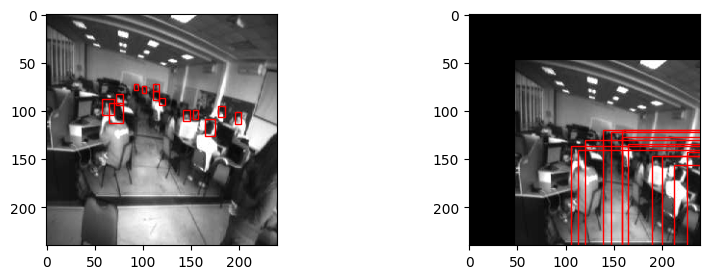

In [ ]:
plot_da(img_ex, bboxes_ex, img_ex_da, bboxes_ex_da)

#### Data Splitting

In [ ]:
import random

In [ ]:
# escoger indices random
train_rel_size = 0.6
train_abs_size = int(train_rel_size * len(gt_lds))

full_idx = list(range(len(gt_lds)))
train_idx = random.sample(range_full, train_abs_size)
test_idx = np.setdiff1d(range_full, train_idx)

# train = gtlds_dic[]

In [ ]:
train.head

In [ ]:
# leer imagenes de LDS
ldsImg = readImg_vec(lds_dataset_loc + gt_lds.filename.unique())

In [ ]:
plt.imshow(ldsImg[6], cmap='gray')

### Generar mapas de densidad

#### Cargar coordenadas de etiquetas

In [ ]:
# coordenadas de cabezas en arreglo np
def coord_arr(id, etapa):
    arch = f"{id:04d}"
    # leer archivo y guardar en un df
    df = txt_df(arch, etapa, [0,1], ["x","y"], " |\n")
    df["id"] = id
    df = df[["id", "x", "y"]]
    coord_arr = df.values
    coord_arr = np.array([np.array(x) for x in coord_arr])
    return coord_arr

# función vectorizada
coord_arr_vec = np.vectorize(coord_arr, otypes=[np.ndarray])

In [ ]:
# labels (ground-truth maps)
train_pxmap = coord_arr_vec(train_data.id, "train/gt")
val_pxmap = coord_arr_vec(val_data.id, "val/gt")
test_pxmap = coord_arr_vec(test_data.id, "test/gt")

In [ ]:
train_pxmap

array([array([[ 17, 322, 247],
              [ 17, 555, 297],
              [ 17, 311, 253],
              [ 17, 256,  52],
              [ 17, 355, 194],
              [ 17, 574, 270],
              [ 17, 115, 189],
              [ 17, 883, 336],
              [ 17,  71,  59],
              [ 17, 723, 264],
              [ 17, 179, 212],
              [ 17, 292, 219],
              [ 17, 494,  90]]), array([[ 19, 119, 366],
                                        [ 19, 544, 349],
                                        [ 19, 201, 349],
                                        [ 19, 410, 339],
                                        [ 19, 535, 365],
                                        [ 19, 607, 390],
                                        [ 19, 928, 389],
                                        [ 19, 621, 354],
                                        [ 19, 190, 399],
                                        [ 19, 342, 392],
                                        [ 19, 722, 356],
 

#### Ajustar coordenadas a dimensiones de entrada de modelo

In [ ]:
# ajustar coordenadas de labels según dimensión de las imágenes
def fix_label_info(label_info, image_width, image_height, original_width, original_height):

    # loop over objects positions and marked them with 100 on a label
    # redundante obtener id de imagen
    if len(label_info) > 0:
      for i, (_, x, y) in enumerate(label_info):

        # calcular nuevas coordenadas a partir de la proporción de cambio
        x = image_width/original_width * x
        y = image_height/original_height * y

        # reemplazar resultados en df
        label_info[i][1] = x
        label_info[i][2] = y

    return label_info

fix_label_info_vec = np.vectorize(fix_label_info, otypes=[np.ndarray])

In [ ]:
train_pxmap_fix = fix_label_info_vec(train_pxmap, width, height, train_data.width, train_data.height)
val_pxmap_fix = fix_label_info_vec(val_pxmap, width, height, val_data.width, val_data.height)
test_pxmap_fix = fix_label_info_vec(test_pxmap, width, height, test_data.width, test_data.height)

#### Filtro gaussiano a partir de etiquetas

In [ ]:
# https://towardsdatascience.com/objects-counting-by-estimating-a-density-map-with-convolutional-neural-networks-c01086f3b3ec

def generate_label(label_info, image_width, image_height):
    """
    Generate a density map based on objects positions.
    Args:
        label_info: (x, y) objects positions
        image_width, image_height: shape of a density map to be generated
    """

    # create an empty density map
    label = np.zeros((image_height, image_width), dtype=np.float32)
    # print("original:", original_shape, "| new:", image_shape)

    if len(label_info) > 0:
        # redundante obtener id de imagen
        for _, x, y in label_info:

            if y < image_height and x < image_width:
                label[int(y)][int(x)] = 1

        # apply a convolution with a Gaussian kernel
        label = gaussian_filter(label, sigma=(1,1), order=0)
    return label

generate_label_vec = np.vectorize(generate_label, otypes=[np.ndarray])

In [ ]:
# conjunto de mapas de densidad
train_density = generate_label_vec(train_pxmap_fix, width, height)
train_density = np.array([np.array(x) for x in train_density])

val_density = generate_label_vec(val_pxmap_fix, width, height)
val_density = np.array([np.array(x) for x in val_density])

test_density = generate_label_vec(test_pxmap_fix, width, height)
test_density = np.array([np.array(x) for x in test_density])

In [ ]:
# almacenar mapas de densidad
np.save('/content/drive/My Drive/Titulo/img_data/train_density.npy', train_density)
np.save('/content/drive/My Drive/Titulo/img_data/val_density.npy', val_density)
np.save('/content/drive/My Drive/Titulo/img_data/test_density.npy', test_density)

#### Resultado

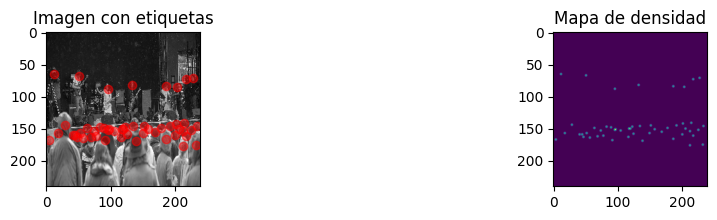

In [ ]:
# almacenar imagen
img_id = train.id[18]
img1 = readJHUImg(train_data.id[img_id], "train").squeeze(axis=-1)

fig, ax = plt.subplots(1, 2, figsize=(12, 2))

# imagen 1
ax[0].set_title("Imagen con etiquetas")
ax[0].imshow(img1, zorder=1, cmap="gray")

# labels como puntos rojos
ax[0].scatter(x=train_pxmap_fix[img_id][:,1], y=train_pxmap_fix[img_id][:,2], zorder=2, c='r', alpha=0.5)

# imagen 2
ax[1].set_title("Mapa de densidad")
ax[1].imshow(train_density[img_id])

plt.show()

1    27
Name: count, dtype: int64


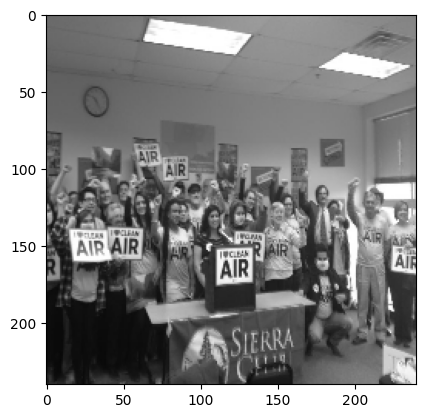

In [ ]:
# Imagen de entrenamiento con su crowd count
train_id = train_data.id[1]
print(train_data[train_data.id==train_id]["count"])
plt.imshow(tripleLayerImg(readJHUImg(train_id, "train")))
plt.show()

Prueba con dimensiones reducidas

In [ ]:
id = train_data.id[235]
ground_truth = coord_arr(id, "train" + "/gt")
ground_truth_fix = fix_label_info(ground_truth, int(width/8), int(height/8), train_data[train_data.id==id].width, train_data[train_data.id==id].height)
density = generate_label(ground_truth_fix, int(width/8), int(height/8))

In [ ]:
plt.imshow(density)
plt.show()
plt.imshow(tripleLayerImg(readJHUImg(id, "train")))
plt.show()

## Diseño de modelos

In [ ]:
# Código para graficar la evolución de las métricas de los modelos

# mae_loss: si la función de pérdida corresponde a MAE
def plot_history(history, mae_loss=False):
    n_cols = 2
    if mae_loss:
        n_cols = 1

    fig, axis = plt.subplots(1, n_cols, figsize=(18,5))

    axis[0].plot(history.history['loss'])
    axis[0].plot(history.history['val_loss'])

    axis[0].set_title("Loss")
    axis[0].set_ylabel('loss')
    axis[0].set_xlabel('epoch')
    axis[0].legend(['train', 'val'], loc='upper left')

    if not mae_loss:
        axis[1].plot(history.history['mae'])
        axis[1].plot(history.history['val_mae'])
        axis[1].set_title("Mean Average Error")
        axis[1].set_ylabel('mae')
        axis[1].set_xlabel('epoch')
        axis[1].legend(['train', 'val'], loc='upper left')

    plt.show()

### Modelo 1

In [ ]:
# Generador de datos de entrenamiento
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator1(tf.keras.utils.Sequence):
    'Generates data for Keras'
    # etapa: train, val o test
    # label_data: dataframe con id, count, width, height de imagenes
    def __init__(self, list_IDs, batch_size, etapa, label_data,
                input_dim=(240, 320), n_channels=3, shuffle=True):
        self.input_dim = input_dim
        # self.output_dim = (int(input_dim[0]/8), int(input_dim[1]/8))
        self.output_dim = (30, 40)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.etapa = etapa
        self.label_data = label_data
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.output_dim))

        # Generate data
        # while True: # probando
        for i, ID in enumerate(list_IDs_temp):

            # leer imagen
            img = readJHUImg(ID, self.etapa)
            # X_train = X_train.astype('float32') / 255

            # triplicar dimension
            img = tripleLayerImg(img)
            X[i,] = img

            # obtener dimensiones originales
            shape = self.label_data[self.label_data["id"]==ID]
            height = shape["height"]
            width = shape["width"]

            # obtener mapa de densidad y ajustar a dimensiones estandar
            ground_truth = coord_arr(ID, self.etapa + "/gt")
            ground_truth_fix = fix_label_info(ground_truth, self.output_dim[1], self.output_dim[0], width, height)
            density = generate_label(ground_truth_fix, self.output_dim[1], self.output_dim[0])

            # ground_truth = coord_arr(train_data.id[101], "train" + "/gt")
            # ground_truth_fix = fix_label_info(ground_truth, int(width/8), int(height/8), train_data.width[101], train_data.height[101])
            # density = generate_label(ground_truth_fix, int(width/8), int(height/8))

            """
            # normalizar
            norm = np.linalg.norm(density)
            if norm != 0:
                density /= norm
            else:
                print("\nWarning: Norm is null. Data kept without normalizing")
                # seria mejor saltarse esta imagen, o dejarla en blanco
                # density /= 1E-10
            """

            y[i] = density

        return X, y

In [ ]:
# definir generadores para los conjuntos de datos
train_generator1 = DataGenerator1(train.id, batch_size=30, etapa="train", label_data=train)
validation_generator1 = DataGenerator1(val.id, batch_size=30, etapa="val", label_data=val)

In [ ]:
def normalize(arr, norm):
    return arr/norm
normalize_vec = np.vectorize(normalize, otypes=[np.ndarray])

In [ ]:
# https://keras.io/api/applications/efficientnet/

# investigar otros modelos más livianos, como efficientdet-lite
# estos modelos finalmente están entrenados para identificar muchos tipos de objeto
# (aunque no sé realmente el impacto de esto en la cantidad de parámetros)
# https://keras.io/api/applications/mobilenet/   | mobilenet_v3_small_1.0_224

base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            weights="imagenet",
            #input_tensor=None,
            input_shape=(height, width, 3),
            #pooling=None,
            #classes=1000,
            # classifier_activation="relu"
)

In [ ]:
base.summary()

In [ ]:
# inspirado en Edge Impulse
for layer in base.layers:

    # congelar capas
    layer.trainable = False
    # acelerar (?)
    if type(layer) == BatchNormalization:
        layer.momentum = 0.9

# cortar capas base
#! Cut the network where it hits 1/8th input resolution; i.e. (HW/8, HW/8, C)
# cut_point = base.get_layer('block_6_expand_relu')

# cut_point = base.get_layer('block3b_expand_conv')
cut_point = base.get_layer( 'block3b_expand_activation')
# cut_point = base.get_layer('block3b_add')
# cut_point = base.get_layer('block1b_add')

#! Now attach a small additional head on the network
x = Conv2D(filters=32, kernel_size=1, strides=1,
    activation='relu', name='head')(cut_point.output)
out = Conv2D(filters=1, kernel_size=1, strides=1,
        activation=None, name='logits')(x)

model = Model(inputs=base.input, outputs=out)

In [ ]:
model.layers[0].input_shape
# model.layers[0].output_shape

In [ ]:
model.summary()

In [ ]:
"""
def ConvBlock(filters):
    x = Conv2D(filters,kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters,kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    return x
"""

In [ ]:
# checkpoints
checkpoint_filepath = '.'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# early stopping
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# https://www.youtube.com/watch?v=U7lLXkSFllA

# ref: https://github.com/Neerajj9/CSRNet-keras
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function)
    # tensorflow.python.framework.ops.Tensor

    # y_true = tf.cast(y_true, tf.float32) # si lo borro? < < < < < < <
    # print("y_true shape", y_true.shape)
    # print("y_pred shape", y_pred.shape)
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    # normalizar matrices
    # HAY QUE NORMALIZAR CADA DATO DEL BATCH
    # norm = np.float32(np.linalg.norm(y_true))

    # print("norm:", norm, "type:", type(norm))

    # loss = KB.sqrt(KB.sum(KB.square(y_pred - y_true), axis=-1))
    # y_true = np.expand_dims(y_true, -1)
    # y_pred = np.expand_dims(y_pred, -1)

    """
    # esta norma está mal, debe ser la norma de cada una de las matrices
    norm = np.float32(np.linalg.norm(y_true))
    if norm != 0:
        y_pred = normalize_vec(y_pred, norm)
        y_pred = normalize_vec(y_pred, norm)
    """


    # y_true = normalize_vec(y_true, norm) # ya está normalizado

    # lo mismo que np.linalg.norm, pero se debe retornar array de tamaño batch_size
    loss = np.sqrt(np.sum(np.sum(np.square(y_pred - y_true), axis=-1), axis=-1))

    print(loss)
    print("loss shape", loss.shape)

    # casteo (?)
    tf_loss = tf.cast(loss, dtype=tf.float32)

    for i,y in enumerate(y_true):
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))

        # imagen 1
        ax[1].set_title("y real")
        ax[1].imshow(y)

        # imagen 2
        ax[0].set_title("y predicho")
        ax[0].imshow(y_pred[i])

        plt.show()

    return tf_loss

In [ ]:
def train_op(y_true, y_pred):

    loss = euclidean_distance_loss(y_true, y_pred)

    # optimizer = tf.keras.optimizers.Adam(0.01)
    optimizer = tf.compat.v1.train.AdamOptimizer(0.01)
    grads_and_vars = optimizer.compute_gradients(loss)
    train_op = optimizer.apply_gradients(grads_and_vars)#, global_step=global_step)


    # grads_and_vars = optimizer.compute_gradients(loss)
    # grads = tf.GradientTape.gradient(loss) # target, sources
    # train_op = optimizer.apply_gradients(grads)#, global_step=global_step)

    return train_op

In [ ]:
tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

# model.compile(optimizer='adam', loss=euclidean_distance_loss, metrics=["accuracy"])
model.compile(optimizer='adam', loss="mse", metrics=["accuracy"])

history = model.fit(train_generator1,
        # steps_per_epoch = len(train_data)/30,
        epochs = 30,
        callbacks=[checkpoint, earlystopping],
        validation_data = validation_generator1,)
        # validation_steps = len(val_data))

Test normalización matriz

In [ ]:
ar = np.array([[1,2,3,4,5,6],
               [3,5,9,11,13,17],
               [0,85,90,100,112,118],
               [5,10,15,20,25,30]])

In [ ]:
np.linalg.norm(ar)

In [ ]:
arrr = np.array([ar for i in range(5)])

In [ ]:
bin_size = 2
output_shape = (int(ar.shape[0]/bin_size), int(ar.shape[1]/bin_size))
small_image = ar.reshape((output_shape[0], bin_size,
                            output_shape[1], bin_size)).max(3).max(1)

Test predicción

In [ ]:
model.load_weights('modelo_light')

In [ ]:
imgtest = readImg(test_data["id"][267], "test")
imgtesttri = tripleLayerImg(imgtest)

In [ ]:
imgtesttriexp = np.expand_dims(imgtesttri, 0)

In [ ]:
predtest = model.predict(imgtesttriexp)[0]
predtesttri = tripleLayerImg(predtest)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# imagen 1
ax[0].set_title("Imagen input")
ax[0].imshow(imgtesttri)

# imagen 2
ax[1].set_title("Mapa de densidad predicho")
# ax[1].imshow(model.predict(imgtesttri))
ax[1].imshow(predtesttri)

plt.show()

In [ ]:
predtesttri.mean()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# imagen 1
ax[0].set_title("Imagen input")
ax[0].imshow(imgtesttri)

# imagen 2
ax[1].set_title("Mapa de densidad predicho")
# ax[1].imshow(model.predict(imgtesttri))
ax[1].imshow(predtesttri)

plt.show()

In [ ]:
# comparación visualización de imagen con 3 canales copiados y grayscale

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# imagen 1
ax[0].set_title("Imagen con un canal")
ax[0].imshow(imgtest.squeeze(axis=-1), cmap="gray")

# imagen 2
ax[1].set_title("Imagen con 3 capas grayscale")
ax[1].imshow(imgtesttri)

plt.show()

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(18,5))

axis[0].plot(history.history['accuracy'])
axis[0].plot(history.history['val_accuracy'])
axis[1].plot(history.history['loss'])
axis[1].plot(history.history['val_loss'])

axis[0].set_title("Accuracy")
axis[0].set_ylabel('accuracy')
axis[0].set_xlabel('epoch')
axis[0].legend(['train', 'val'], loc='upper left')

axis[1].set_title("Loss")
axis[1].set_ylabel('loss')
axis[1].set_xlabel('epoch')
axis[1].legend(['train', 'val'], loc='upper left')
plt.show()

#### Fine-tuning + capa final de enumeración

#### Guardar modelo

In [ ]:
# guardar en archivo
model.save_weights('./model_acc_45')

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.allow_custom_ops = True
# converter.representative_dataset = rep_data_gen
converter.experimental_new_converter = True

# Save the model.
tflite_model = converter.convert()
open('model_light.tflite', 'wb').write(tflite_model)

### MobileNetV2 standalone

Uso de MobileNetV2 completo, con capas convolucionales entrenadas con dataset LDS, y utilizando una capa de regresión para contar personas.

##### Preprocesamiento modelo

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Concatenate

In [ ]:
# img_conc = Concatenate()([img_input, img_input, img_input])
# img_input = Input(shape=(224, 224, 3))

In [ ]:
mobile_net_v2 = MobileNetV2(input_shape=(224,224,3), include_top=False)

In [ ]:
mobile_net_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
# probar con block_9
cut_point = mobile_net_v2.get_layer('block_4_expand_relu')

for layer in mobile_net_v2.layers:
    layer.trainable = False

# conv1 = Conv2D(filters=360, kernel_size=1, strides=1,
            # activation='relu', name='head1')(cut_point.output)
# conv2 = Conv2D(filters=180, kernel_size=1, strides=1,
#             activation=None, name='head2')(cut_point.output)
conv3 = Conv2D(filters=90, kernel_size=1, strides=1,
            activation=None, name='head3')(cut_point.output)
conv4 = Conv2D(filters=32, kernel_size=1, strides=1,
                activation=None, name='head4')(conv3)
flatten = Flatten()(conv4)
final = Dense(1, activation='linear')(flatten)

model_mnv2 = Model(inputs=mobile_net_v2.input, outputs=final)

In [ ]:
model_mnv2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

##### Preprocesamiento dataset LDS

In [ ]:
# entrenar con dataset LDS
from json import loads

lds_dataset_loc = "/content/drive/My Drive/Titulo/Dataset LDS/"
lds_info = pd.read_csv(lds_dataset_loc + "vialabels.csv")

#lds_info
lds_dataset = lds_info.drop_duplicates("filename")
lds_dataset = lds_dataset[["filename","region_count"]].reset_index(drop=True)
lds_dataset["region_count"] = lds_dataset["region_count"].astype(np.float32)
lds_dataset

filename  region_count
0    lds000.jpg           3.0
1    lds001.jpg           5.0
2     lds01.jpg           2.0
3    lds002.jpg           7.0
4    lds003.jpg           3.0
5    lds004.jpg           3.0
6    lds005.jpg           2.0
7    lds006.jpg           1.0
8    lds007.jpg           1.0
9    lds008.jpg           1.0
10   lds009.jpg           8.0
11   lds010.jpg           2.0
12  lds0012.jpg           1.0
13  lds0013.jpg           1.0
14  lds0014.jpg           1.0
15  lds0015.jpg           0.0
16  lds0016.jpg           0.0
17  lds0017.jpg           1.0
18  lds0018.jpg           6.0
19  lds0019.jpg           5.0
20  lds0021.jpg           7.0
21  lds0022.jpg           6.0
22  lds0024.jpg           4.0
23  lds0025.jpg           5.0
24  lds0026.jpg           4.0
25  lds0027.jpg           2.0
26  lds0028.jpg           1.0
27  lds0029.jpg           3.0
28  lds0030.jpg           5.0
29  lds0031.jpg           8.0
30  lds0032.jpg           5.0
31  lds0033.jpg           1.0
32  lds0034.jpg          13.0
33  lds0035.jpg          17.0
34  lds0036.jpg           7.0
35  lds0037.jpg          12.0
36  lds0039.jpg          13.0
37  lds0040.jpg           4.0
38  lds0041.jpg           7.0
39  lds0042.jpg           6.0
40  lds0043.jpg           5.0
41  lds0044.jpg          12.0

Splitting

In [ ]:
import random

In [ ]:
X_lds = readImg_vec(lds_dataset_loc + lds_dataset.filename)

In [ ]:
# lds_dataset['img'] = pd.DataFrame(X_lds, columns=["img"])

In [ ]:
lds_dataset

filename  region_count  \
0    lds000.jpg             3   
1    lds001.jpg             5   
2     lds01.jpg             2   
3    lds002.jpg             7   
4    lds003.jpg             3   
5    lds004.jpg             3   
6    lds005.jpg             2   
7    lds006.jpg             1   
8    lds007.jpg             1   
9    lds008.jpg             1   
10   lds009.jpg             8   
11   lds010.jpg             2   
12  lds0012.jpg             1   
13  lds0013.jpg             1   
14  lds0014.jpg             1   
15  lds0015.jpg             0   
16  lds0016.jpg             0   
17  lds0017.jpg             1   
18  lds0018.jpg             6   
19  lds0019.jpg             5   
20  lds0021.jpg             7   
21  lds0022.jpg             6   
22  lds0024.jpg             4   
23  lds0025.jpg             5   
24  lds0026.jpg             4   
25  lds0027.jpg             2   
26  lds0028.jpg             1   
27  lds0029.jpg             3   
28  lds0030.jpg             5   
29  lds0031.jpg             8   
30  lds0032.jpg             5   
31  lds0033.jpg             1   
32  lds0034.jpg            13   
33  lds0035.jpg            17   
34  lds0036.jpg             7   
35  lds0037.jpg            12   
36  lds0039.jpg            13   
37  lds0040.jpg             4   
38  lds0041.jpg             7   
39  lds0042.jpg             6   
40  lds0043.jpg             5   
41  lds0044.jpg            12   

                                                  img  
0   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
1   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
2   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
3   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
4   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
5   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
6   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
7   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
8   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
9   [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
10  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
11  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
12  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
13  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
14  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
15  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
16  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
17  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
18  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
19  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
20  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
21  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
22  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
23  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
24  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
25  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
26  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
27  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
28  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
29  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
30  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
31  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
32  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
33  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
34  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
35  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
36  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
37  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
38  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
39  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
40  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  
41  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...

In [ ]:
lds_dataset.iloc[40]['filename']

'lds0043.jpg'

In [ ]:
# escoger indices random
train_rel_size = 0.75
train_abs_size = int(train_rel_size * len(lds_dataset))

full_idx = list(range(len(lds_dataset)))
train_idx = random.sample(full_idx, train_abs_size)
test_idx = np.setdiff1d(full_idx, train_idx)

train_lds = lds_dataset.iloc[train_idx].reset_index()
test_lds = lds_dataset.iloc[test_idx].reset_index()

In [ ]:
np.dstack([X_lds[0],X_lds[0],X_lds[0]]).shape

(224, 224, 3)

In [ ]:
X_train_lds = np.array([np.array(np.dstack([x,x,x]), dtype=np.float32) for x in X_lds[train_idx]])
X_test_lds = np.array([np.array(np.dstack([x,x,x]), dtype=np.float32) for x in X_lds[test_idx]])

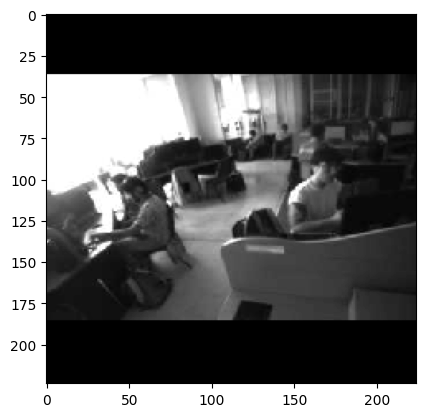

In [ ]:
# plt.imshow(readImg(lds_dataset_loc + train_lds.iloc[5]["filename"]), cmap='gray')
plt.imshow(X_train_lds[5], cmap='gray')

##### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Assume 'x_train' is your input dataset of images
datagen.fit(X_train_lds)

batch_size = 100

# Generate augmented data
augmented_train_generator = datagen.flow(X_train_lds,
                                        train_lds.region_count,
                                        batch_size=batch_size)

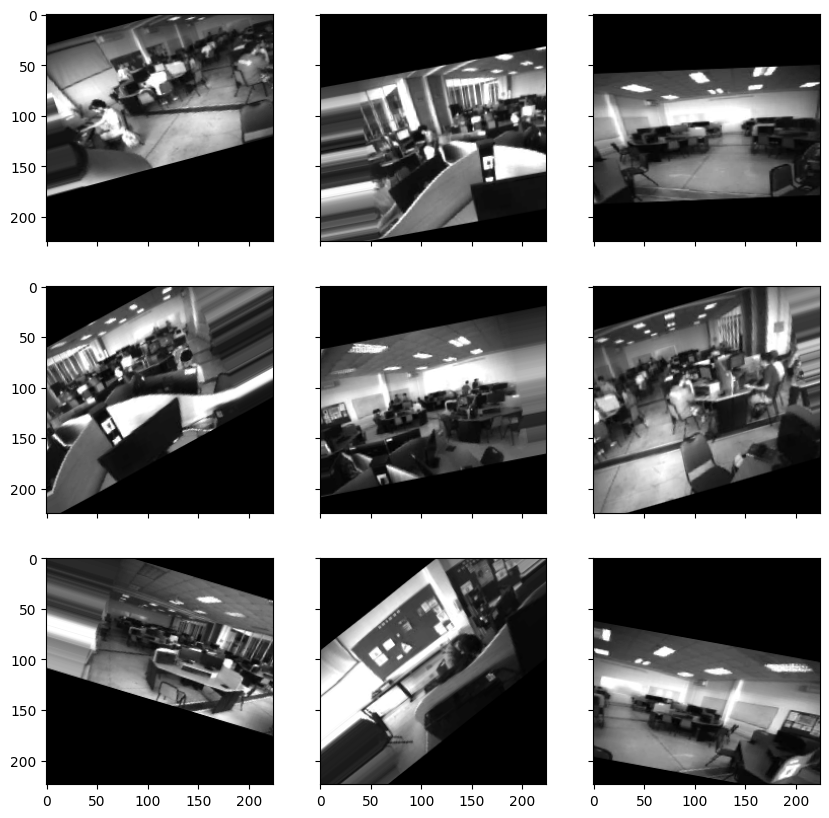

In [ ]:
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
for X_batch, y_batch in datagen.flow(X_train_lds, train_lds.region_count, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j,:,:,0].reshape(224,224), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

In [ ]:
model_mnv2.compile(optimizer='adam',
                    loss="mae",
                    metrics=["mae"])

history_mnv2_da = model_mnv2.fit(augmented_train_generator,
                                #steps_per_epoch=len(X_train) // batch_size,
                                epochs=60,
                                validation_data = (X_test_lds, test_lds.region_count))

Epoch 1/60
1/1 [==============================] - 7s 7s/step - loss: 6.1713 - mae: 6.1713 - val_loss: 45.0393 - val_mae: 45.0393
Epoch 2/60
1/1 [==============================] - 2s 2s/step - loss: 43.5937 - mae: 43.5937 - val_loss: 31.5429 - val_mae: 31.5429
Epoch 3/60
1/1 [==============================] - 1s 1s/step - loss: 30.2994 - mae: 30.2994 - val_loss: 9.3430 - val_mae: 9.3430
Epoch 4/60
1/1 [==============================] - 1s 1s/step - loss: 8.2239 - mae: 8.2239 - val_loss: 13.2506 - val_mae: 13.2506
Epoch 5/60
1/1 [==============================] - 1s 1s/step - loss: 14.2550 - mae: 14.2550 - val_loss: 14.9445 - val_mae: 14.9445
Epoch 6/60
1/1 [==============================] - 1s 1s/step - loss: 16.1224 - mae: 16.1224 - val_loss: 5.8138 - val_mae: 5.8138
Epoch 7/60
1/1 [==============================] - 3s 3s/step - loss: 7.3666 - mae: 7.3666 - val_loss: 10.3987 - val_mae: 10.3987
Epoch 8/60
1/1 [==============================] - 1s 1s/step - loss: 8.0504 - mae: 8.0504 - v

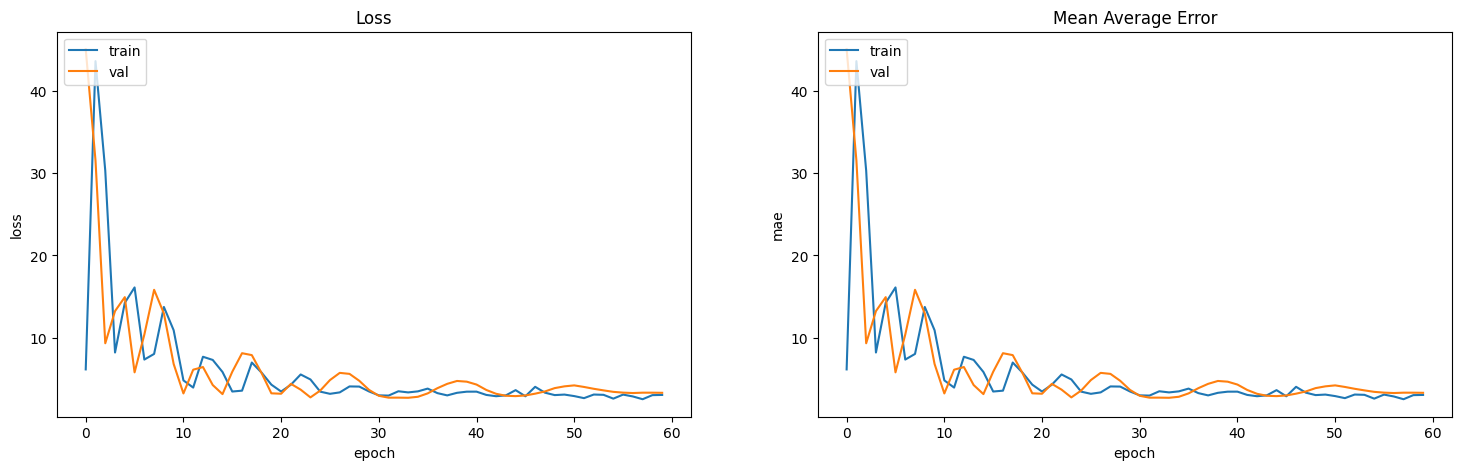

In [ ]:
plot_history(history_mnv2_da)

##### Data Generators

In [ ]:
# Generador de datos de entrenamiento
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGeneratorMNV2(tf.keras.utils.Sequence):
    'Generates data for Keras'
    # label_data: dataframe con id, count, width, height de imagenes
    def __init__(self, dataset, batch_size,
                input_dim=(224, 224), n_channels=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.output_dim = [1]
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.dataset.iloc[k]["filename"] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.output_dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            # leer imagen
            img = readImg(lds_dataset_loc + ID)
            # X_train = X_train.astype('float32') / 255

            # triplicar dimension (no en este caso)
            # img = tripleLayerImg(img)
            X[i,] = img

            # y debe ser la cantidad de personas
            y[i] = self.dataset[self.dataset["filename"]==ID]["region_count"]

        return X, y

In [ ]:
# definir generadores para los conjuntos de datos
train_generator_mnv2 = DataGeneratorMNV2(train_lds, batch_size=3)
validation_generator_mnv2 = DataGeneratorMNV2(test_lds, batch_size=3)

In [ ]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()
model_mnv2.compile(optimizer='adam',
                loss=weighted_categorical_crossentropy(100),
                metrics=["mae"])

history_mnv2 = model_mnv2.fit(train_generator_mnv2,
                        # steps_per_epoch = len(train_data)/30,
                        epochs = 30,
                        validation_data = validation_generator_mnv2)

Epoch 1/30
10/10 [==============================] - 16s 1s/step - loss: 6.0797e-05 - mae: 6.6814 - val_loss: 4.9008e-05 - val_mae: 7.8287
Epoch 2/30
10/10 [==============================] - 2s 196ms/step - loss: 5.8810e-05 - mae: 6.5376 - val_loss: 4.2386e-05 - val_mae: 8.4472
Epoch 3/30
10/10 [==============================] - 3s 289ms/step - loss: 6.1989e-05 - mae: 6.6296 - val_loss: 4.5035e-05 - val_mae: 7.9574
Epoch 4/30
10/10 [==============================] - 1s 96ms/step - loss: 5.9207e-05 - mae: 6.7194 - val_loss: 5.1657e-05 - val_mae: 7.3389
Epoch 5/30
10/10 [==============================] - 1s 120ms/step - loss: 5.9605e-05 - mae: 6.5659 - val_loss: 4.6359e-05 - val_mae: 7.3569
Epoch 6/30
10/10 [==============================] - 1s 108ms/step - loss: 6.0797e-05 - mae: 6.6629 - val_loss: 3.8412e-05 - val_mae: 8.6976
Epoch 7/30
10/10 [==============================] - 1s 113ms/step - loss: 5.5234e-05 - mae: 6.7865 - val_loss: 5.2982e-05 - val_mae: 7.5744
Epoch 8/30
10/10 [=====

In [ ]:
model_mnv2.save("model_mnv2_retrained.h5")

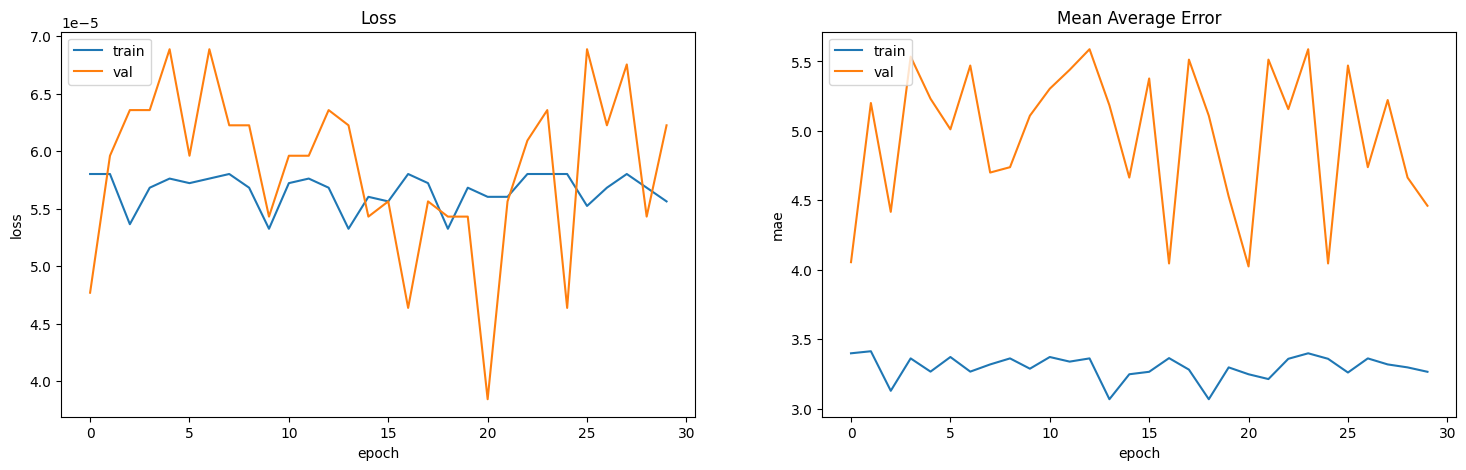

In [ ]:
plot_history(history_mnv2)

##### Test

1/1 [==============================] - 2s 2s/step
[[3.0238433]]


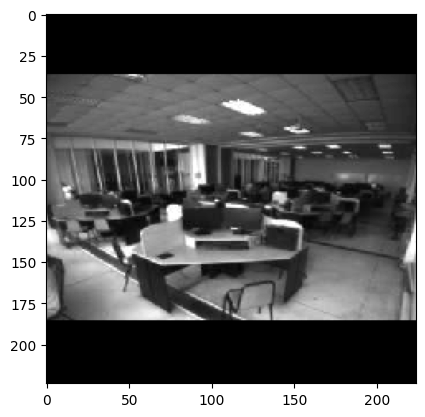

In [ ]:
imgtestlds = readImg(lds_dataset_loc + train_lds.iloc[6]["filename"])
imgtestlds_exp = np.expand_dims(imgtestlds,0)

print(model_mnv2.predict(imgtestlds_exp))
plt.imshow(imgtestlds, cmap='gray')
plt.show()

##### TF Lite

In [ ]:
def representative_dataset():
    for i in range(10):
        # x_rep = readImg_vec(lds_dataset_loc + test_lds["filename"])
        # x_rep = np.array([np.array(x) for x in x_rep])
        x_rep = np.expand_dims(X_train[i],0)
        yield [x_rep]

In [ ]:
# Probando modelos sin optimizar para analizar output en Arduino IDE

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model_mnv2)

#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_dataset
# converter.experimental_new_converter = True
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8

# Save the model.
model_mnv2_lite = converter.convert()
open('model_mnv2.tflite', 'wb').write(model_mnv2_lite)

315648

In [ ]:
# convertir a hex con Unix
!xxd -i model_mnv2.tflite > model_mnv2_data.cc

In [ ]:
mnv2_model = keras.models.load_model("mnv2_model_retrained.h5", compile=False)

### EfficientNet standalone

In [ ]:
!tar -xvzf efficientdet.tar.gz

./
saved_model.pb
variables/
variables/variables.data-00000-of-00001
variables/variables.index


In [ ]:
!saved_model_cli show --dir {./efficientdet} --all

2023-10-04 21:54:32.332492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 1309, in main
    app.run(smcli_main)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 1307, in smcli_main
    args.func()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 968, in show
    _show_all(_SMCLI_DIR.value)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 516, in _show_all
    saved_model

In [ ]:
#efficientdet = tf.keras.models.load_model('saved_model.pb')

with tf.compat.v1.Session(graph=tf.Graph()) as sess:
    tf.compat.v1.saved_model.loader.load(sess, [tf.compat.v1.saved_model.tag_constants.SERVING], './efficientdet')
    graph = tf.compat.v1.get_default_graph()
    y_pred = sess.run('your_output_name:0', feed_dict={'your_input_name:0': x})


OSError: ignored

### Modelo Edge Impulse (FOMO + MobileNetV2)

#### FOMO

In [ ]:
# Edge Impulse (studio.edgeimpulse.com)
def build_model(input_shape: tuple, weights: str, alpha: float,
                num_classes: int) -> tf.keras.Model:
    """ Construct a constrained object detection model.

    Args:
        input_shape: Passed to MobileNet construction.
        weights: Weights for initialization of MobileNet where None implies
            random initialization.
        alpha: MobileNet alpha value.
        num_classes: Number of classes, i.e. final dimension size, in output.

    Returns:
        Uncompiled keras model.

    Model takes (B, H, W, C) input and
    returns (B, H//8, W//8, num_classes) logits.
    """

    #! First create full mobile_net_V2 from (HW, HW, C) input
    #! to (HW/8, HW/8, C) output
    mobile_net_v2 = MobileNetV2(input_shape=input_shape,
                                weights=weights,
                                alpha=alpha,
                                include_top=True)
    #! Default batch norm is configured for huge networks, let's speed it up
    for layer in mobile_net_v2.layers:
        if type(layer) == BatchNormalization:
            layer.momentum = 0.9
    #! Cut MobileNet where it hits 1/8th input resolution; i.e. (HW/8, HW/8, C)
    cut_point = mobile_net_v2.get_layer('block_6_expand_relu')
    #! Now attach a small additional head on the MobileNet
    model = Conv2D(filters=32, kernel_size=1, strides=1,
                activation='relu', name='head')(cut_point.output)
    logits = Conv2D(filters=num_classes, kernel_size=1, strides=1,
                    activation=None, name='logits')(model)
    return Model(inputs=mobile_net_v2.input, outputs=logits)

def train(num_classes: int,
          learning_rate: float,
          num_epochs: int,
          alpha: float,
          object_weight: int,
          train_dataset: tf.data.Dataset,
          validation_dataset: tf.data.Dataset,
          best_model_path: str,
          input_shape: tuple,
          lr_finder: bool = False) -> tf.keras.Model:
    """ Construct and train a constrained object detection model.

    Args:
        num_classes: Number of classes in datasets. This does not include
            implied background class introduced by segmentation map dataset
            conversion.
        learning_rate: Learning rate for Adam.
        num_epochs: Number of epochs passed to model.fit
        alpha: Alpha used to construct MobileNet. Pretrained weights will be
            used if there is a matching set.
        object_weight: The weighting to give the object in the loss function
            where background has an implied weight of 1.0.
        train_dataset: Training dataset of (x, (bbox, one_hot_y))
        validation_dataset: Validation dataset of (x, (bbox, one_hot_y))
        best_model_path: location to save best model path. note: weights
            will be restored from this path based on best val_f1 score.
        input_shape: The shape of the model's input
        max_training_time_s: Max training time (will exit if est. training time is over the limit)
        is_enterprise_project: Determines what message we print if training time exceeds
    Returns:
        Trained keras model.

    Constructs a new constrained object detection model with num_classes+1
    outputs (denoting the classes with an implied background class of 0).
    Both training and validation datasets are adapted from
    (x, (bbox, one_hot_y)) to (x, segmentation_map). Model is trained with a
    custom weighted cross entropy function.
    """

    num_classes_with_background = num_classes + 1

    input_width_height = None
    width, height, input_num_channels = input_shape
    if width != height:
        raise Exception(f"Only square inputs are supported; not {input_shape}")
    input_width_height = width

    #! Use pretrained weights, if we have them for configured
    weights = None
    if input_num_channels == 1:
        if alpha == 0.1:
            weights = "./transfer-learning-weights/edgeimpulse/MobileNetV2.0_1.96x96.grayscale.bsize_64.lr_0_05.epoch_441.val_loss_4.13.val_accuracy_0.2.hdf5"
        elif alpha == 0.35:
            weights = "./transfer-learning-weights/edgeimpulse/MobileNetV2.0_35.96x96.grayscale.bsize_64.lr_0_005.epoch_260.val_loss_3.10.val_accuracy_0.35.hdf5"
    elif input_num_channels == 3:
        if alpha == 0.1:
            weights = "./transfer-learning-weights/edgeimpulse/MobileNetV2.0_1.96x96.color.bsize_64.lr_0_05.epoch_498.val_loss_3.85.hdf5"
        elif alpha == 0.35:
            weights = "./transfer-learning-weights/keras/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_96.h5"

    if (weights is not None) and (not os.path.exists(weights)):
        print(f"WARNING: Pretrained weights {weights} unavailable; defaulting to random init")
        weights = None

    model = build_model(
        input_shape=input_shape,
        weights=weights,
        alpha=alpha,
        num_classes=num_classes_with_background
    )

    #! Derive output size from model
    model_output_shape = model.layers[-1].output.shape
    _batch, width, height, num_classes = model_output_shape
    if width != height:
        raise Exception(f"Only square outputs are supported; not {model_output_shape}")
    output_width_height = width

    #! Build weighted cross entropy loss specific to this model size
    weighted_xent = models.construct_weighted_xent_fn(model.output.shape, object_weight)

    #! Transform bounding box labels into segmentation maps
    train_segmentation_dataset = train_dataset.map(dataset.bbox_to_segmentation(
        output_width_height, num_classes_with_background)).batch(32, drop_remainder=False).prefetch(1)
    validation_segmentation_dataset = validation_dataset.map(dataset.bbox_to_segmentation(
        output_width_height, num_classes_with_background, validation=True)).batch(32, drop_remainder=False).prefetch(1)

    #! Initialise bias of final classifier based on training data prior.
    util.set_classifier_biases_from_dataset(
        model, train_segmentation_dataset, num_classes_with_background)

    if lr_finder:
        learning_rate = ei_tensorflow.lr_finder.find_lr(model, train_segmentation_dataset, weighted_xent)

    model.compile(loss=weighted_xent,
                  optimizer=Adam(learning_rate=learning_rate))

    #! Create callback that will do centroid scoring on end of epoch against
    #! validation data. Include a callback to show % progress in slow cases.
    callbacks = callbacks if callbacks else []
    callbacks.append(metrics.CentroidScoring(validation_segmentation_dataset,
                                             output_width_height, num_classes_with_background))
    callbacks.append(metrics.PrintPercentageTrained(num_epochs))

    #! Include a callback for model checkpointing based on the best validation f1.
    callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(best_model_path,
            monitor='val_f1', save_best_only=True, mode='max',
            save_weights_only=True, verbose=0))

    model.fit(train_segmentation_dataset,
              validation_data=validation_segmentation_dataset,
              epochs=num_epochs, callbacks=callbacks, verbose=0)

    #! Restore best weights.
    model.load_weights(best_model_path)

    #! Add explicit softmax layer before export.
    softmax_layer = Softmax()(model.layers[-1].output)
    model = Model(model.input, softmax_layer)

    return model

model = train(num_classes=classes,
              learning_rate=0.001,
              num_epochs=60,
              alpha=0.35,
              object_weight=100,
              train_dataset=train_dataset,
              validation_dataset=validation_dataset,
              best_model_path=BEST_MODEL_PATH,
              input_shape=MODEL_INPUT_SHAPE,
              lr_finder=False)

override_mode = 'segmentation'
disable_per_channel_quantization = False


In [ ]:
# borrar
model_ei = keras.models.load_model("model_ei.h5")
model_ei.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 120, 16  144         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 120, 16  64          ['Conv1[0][0]']                  
                                )                                                           

#### Generar etiquetas

In [ ]:
# MOVER ARRIBA, PORQUE HAY METODOS DE AQUI QUE SE OCUPAN PREVIAMENTE

# coordenadas de bounding boxes
def bbox_arr(id, etapa):
    arch = f"{id:04d}"
    # leer archivo y guardar en un df
    df = txt_df(arch, etapa, [0,1,2,3], ["x","y","w","h"], " |\n")
    df["id"] = id
    df = df[["id", "x", "y", "w", "h"]]

    # x,y a inicio de bounding box, en vez de indicar el centroide
    w = (df["w"]/2).astype(int)
    h = (df["h"]/2).astype(int)

    df["x"] = df["x"] - w
    df["y"] = df["y"] - h

    # funciona, pero hay casos en los que el inicio del bbox está fuera de la imagen
    # no es cosa de llegar y convertirlos en 0, porque el ancho y largo se mantendrían,
    # corriendo el cuadro

    # YA, DESPUÉS LO ARREGLO, prueba no mas si funciona el mapa de segmentacion por ahora ;-;
    # edit: si funciona
    # edit:edit:entonces hay que arreglarlooo

    bbox_arr = df.values
    bbox_arr = np.array([np.array(x) for x in bbox_arr])
    return bbox_arr

# función vectorizada
bbox_arr_vec = np.vectorize(bbox_arr, otypes=[np.ndarray])

In [ ]:
# labels (ground-truth maps)
train_bbox = bbox_arr_vec(train_data.id, "train/gt")
val_bbox = bbox_arr_vec(val_data.id, "val/gt")
test_bbox = bbox_arr_vec(test_data.id, "test/gt")

In [ ]:
# ajustar coordenadas de labels según dimensión de las imágenes
def fix_bbox_info(bbox_info, image_width, image_height, original_width, original_height, is_jhu_dataset=True):

    if is_jhu_dataset:
        idx = range(1,5)
    else:
        idx = range(4)

    # redundante obtener id de imagen (era por si acaso)
    if len(bbox_info) > 0:
      for i, (*_, x, y, w, h) in enumerate(bbox_info):

        # calcular nuevas coordenadas a partir de la proporción de cambio
        x = image_width/original_width * x
        y = image_height/original_height * y
        w = image_width/original_width * w
        h = image_height/original_height * h

        # reemplazar resultados en df
        bbox_info[i][idx[0]] = x
        bbox_info[i][idx[1]] = y
        bbox_info[i][idx[2]] = w
        bbox_info[i][idx[3]] = h

    return bbox_info

fix_bbox_info_vec = np.vectorize(fix_bbox_info, otypes=[np.ndarray])

In [ ]:
train_bbox_fix = fix_bbox_info_vec(train_bbox, width, height, train_data.width, train_data.height)
val_bbox_fix = fix_bbox_info_vec(val_bbox, width, height, val_data.width, val_data.height)
test_bbox_fix = fix_bbox_info_vec(test_bbox, width, height, test_data.width, test_data.height)

In [ ]:
# Función para generar una matriz que contenga los mapas de segmentación
# de las clases a identificar. En este caso, background y person

# bbox_info: tupla de coordenadas de las bounding boxes de la imagen (x,y,w,h)
def bbox_to_seg_map(bbox_info, image_width, image_height):
    mask = np.zeros((image_height, image_width, 2), dtype=np.float32)

    if len(bbox_info) > 0:
        # redundante obtener id de imagen
        for _, x, y, w, h in bbox_info:

            if y < image_height and y+h < image_height and x < image_width and x + w < image_width:
                # label[int(y)][int(x)] = 1
                mask[y:y+h,x:x+w,1] = 1
            # else:
                # print("[{}]: Error al generar mapa de segmentación, etiqueta sale de los limites de la imagen".format(id))

            mask[:,:,0] = 1 - mask[:,:,1]

    return mask

bbox_to_seg_vec = np.vectorize(bbox_to_seg_map, otypes=[np.ndarray])

In [ ]:
# conjunto de mapas de segmentación
train_seg = bbox_to_seg_vec(train_bbox_fix, width, height)
train_seg = np.array([np.array(x) for x in train_seg])

val_seg = bbox_to_seg_vec(val_bbox_fix, width, height)
val_seg = np.array([np.array(x) for x in val_seg])

test_seg = bbox_to_seg_vec(test_bbox_fix, width, height)
test_seg = np.array([np.array(x) for x in test_seg])

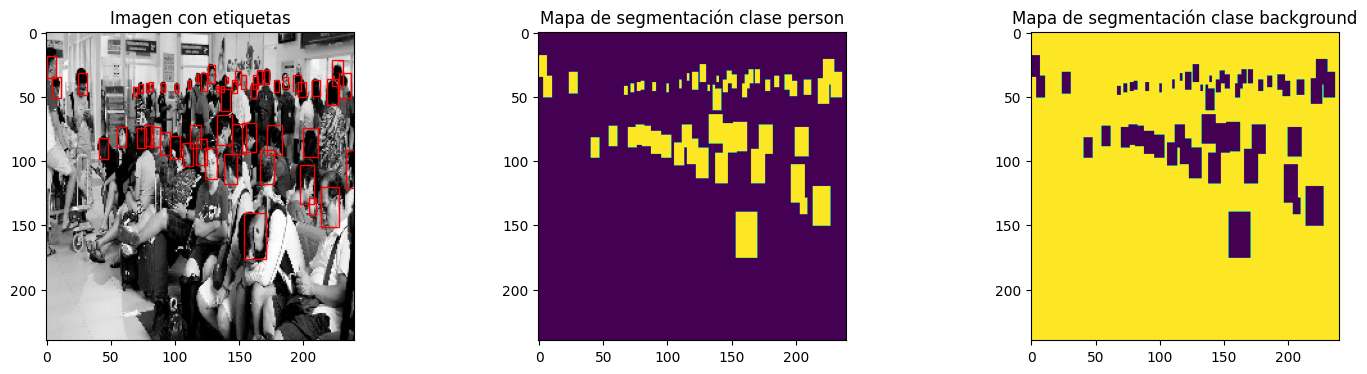

In [ ]:
ex_idx = 19
img_id = train_bbox_fix[ex_idx][0][0]
ex_img = readJHUImg(img_id, "train").squeeze(axis=-1)

fig, ax = plt.subplots(1,3,figsize=(18,4))

ax[0].set_title("Imagen con etiquetas")
ax[0].imshow(ex_img, zorder=1, cmap="gray")
for _,x,y,w,h in train_bbox_fix[ex_idx]:
    ax[0].add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', fill=None))

ax[1].set_title("Mapa de segmentación clase person")
ax[1].imshow(train_seg[ex_idx,:,:,1])
ax[2].set_title("Mapa de segmentación clase background")
ax[2].imshow(train_seg[ex_idx,:,:,0])

plt.show()

Una vez preparados los datos de la sala a probar, con sus respectivas etiquetas, se procede a reentrenar las capas superiores del modelo base (FOMO).

#### Reentrenamiento

In [ ]:
ei_model = keras.models.load_model("model_ei.h5")

for layer in ei_model.layers:
    layer.trainable = False

cut_point = ei_model.get_layer('head')
headx_layer = Conv2D(filters=32, kernel_size=1, strides=1,
            activation='relu', name='headx')(cut_point.output)
logits = Conv2D(filters=2, kernel_size=1, strides=1,
                activation=None, name='logits')(headx_layer)
ei_model = Model(inputs=ei_model.input, outputs=logits)

# por lo menos en este modelo no se usan nunca dos capas convolucionales seguidas, pero igual podría ayudar
# de todas formas, sería bueno preguntar a alguien que cache

In [ ]:
ei_model.summary()

In [ ]:
# Generador de datos de entrenamiento
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGeneratorFomo(tf.keras.utils.Sequence):
    'Generates data for Keras'
    # etapa: train, val o test
    # label_data: dataframe con id, count, width, height de imagenes
    def __init__(self, list_IDs, batch_size, etapa, label_data,
                input_dim=(240, 240), n_channels=1, shuffle=True):
        self.input_dim = input_dim
        # en este caso cuenta con una dimensión extra para representar los
        # dos mapas de segmentación de las clases 'background' y 'person'
        self.output_dim = (30, 30, 2)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.etapa = etapa
        self.label_data = label_data
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.output_dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            # leer imagen
            img = readJHUImg(ID, self.etapa)
            # X_train = X_train.astype('float32') / 255

            # triplicar dimension (no en este caso)
            # img = tripleLayerImg(img)
            X[i,] = img

            # obtener dimensiones originales (en este caso debería height == width)
            shape = self.label_data[self.label_data["id"]==ID]
            height = shape["height"]
            width = shape["width"]

            # obtener mapa de segmentación y ajustar a dimensiones estandar
            ground_truth = bbox_arr(ID, self.etapa + "/gt")
            ground_truth_fix = fix_bbox_info(ground_truth, self.output_dim[1], self.output_dim[0], width, height)
            seg_map = bbox_to_seg_map(ground_truth_fix, self.output_dim[1], self.output_dim[0])

            y[i] = seg_map

        return X, y

In [ ]:
# definir generadores para los conjuntos de datos
train_generator_fomo = DataGeneratorFomo(train_data.id, batch_size=30, etapa="train", label_data=train_data)
validation_generator_fomo = DataGeneratorFomo(val_data.id, batch_size=30, etapa="val", label_data=val_data)

A continuación se prueban distintas funciones de pérdida para comparar los distintos rendimientos de los modelos obtenidos.

##### Cross-entropy con pesos

In [ ]:
class WeightedCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, weight, epsilon=1e-7, name="weighted_cross_entropy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.weight = weight
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, self.epsilon, 1 - self.epsilon)
        loss = -(self.weight * y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        return tf.math.reduce_mean(loss)

    def get_config(self):
        config = {
            'weight': self.weight,
            'epsilon': self.epsilon
        }
        base_config = super().get_config()
        return {**base_config, **config}

In [ ]:
def weighted_categorical_crossentropy(weights):
    """ weighted_categorical_crossentropy

        Args:
            * weights<ktensor|nparray|list>: crossentropy weights
        Returns:
            * weighted categorical crossentropy function
    """
    if isinstance(weights,list) or isinstance(weights,np.ndarray):
        weights=KB.variable(weights)

    def loss(target,output,from_logits=False):
        if not from_logits:
            output /= tf.reduce_sum(output,
                                    len(output.get_shape()) - 1,
                                    True)
            _epsilon = tf.convert_to_tensor(KB.epsilon(), dtype=output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
            weighted_losses = target * tf.math.log(output) * weights
            return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1)
        else:
            raise ValueError('WeightedCategoricalCrossentropy: not valid with logits')
    return loss

In [ ]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()
ei_wce_model = ei_model
ei_wce_model.compile(optimizer='adam', loss=weighted_categorical_crossentropy(100), metrics=["mae"])

history_wce = ei_wce_model.fit(train_generator_fomo,
            # steps_per_epoch = len(train_data)/30,
            epochs = 50,
            validation_data = validation_generator_fomo)

In [ ]:
ei_wce_model.save("model_ei_wce_retrained.h5")

In [ ]:
ei_wce_model = keras.models.load_model("model_ei_wce_retrained.h5", compile=False)

In [ ]:
plot_history(history_wce)

##### Cross-entropy regular

In [ ]:
ei_ce_model = ei_model
ei_ce_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["mae"])

history_ce = ei_ce_model.fit(train_generator_fomo,
            # steps_per_epoch = len(train_data)/30,
            epochs = 50,
            validation_data = validation_generator_fomo)

In [ ]:
ei_ce_model.save("model_ei_ce_retrained.h5")

In [ ]:
ei_ce_model = keras.models.load_model("model_ei_ce_retrained.h5", compile=False)

In [ ]:
plot_history(history_ce)

##### MAE

In [ ]:
ei_ce_model = ei_model
ei_mae_model.compile(optimizer='adam', loss="mae", metrics=["mae"])

history_mae = ei_mae_model.fit(train_generator_fomo,
            # steps_per_epoch = len(train_data)/30,
            epochs = 50,
            validation_data = validation_generator_fomo)

In [ ]:
ei_mae_model.save("model_ei_ce_retrained.h5")

In [ ]:
ei_mae_model = keras.models.load_model("model_ei_mae_retrained.h5", compile=False)

In [ ]:
plot_history(history_mae, mae_loss=True)

##### Poisson (?)

In [ ]:
ei_p_model = ei_model
ei_p_model.compile(optimizer='adam', loss=tf.keras.losses.Poisson(), metrics=["mae"])

history_ce = ei_ce_model.fit(train_generator_fomo,
            # steps_per_epoch = len(train_data)/30,
            epochs = 50,
            validation_data = validation_generator_fomo)

In [ ]:
ei_ce_model.save("model_ei_ce_retrained.h5")

In [ ]:
ei_ce_model = keras.models.load_model("model_ei_ce_retrained.h5", compile=False)

In [ ]:
plot_history(history_ce)

#### Resultados y prueba

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(18,5))

axis[0].plot(history.history['loss'])
axis[0].plot(history.history['val_loss'])
axis[1].plot(history.history['mae'])
axis[1].plot(history.history['val_mae'])

axis[0].set_title("Loss")
axis[0].set_ylabel('loss')
axis[0].set_xlabel('epoch')
axis[0].legend(['train', 'val'], loc='upper left')

axis[1].set_title("Mean Average Error")
axis[1].set_ylabel('mae')
axis[1].set_xlabel('epoch')
axis[1].legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
imgtest = readJHUImg(test_data["id"][51], "test")
imgtestexp = np.expand_dims(imgtest, 0)

In [ ]:
pred = ei_model.predict(imgtestexp)

In [ ]:
# imagen de 3 capas para imprimir
imgtesttri = tripleLayerImg(imgtest)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# imagen 1
ax[0].set_title("Imagen de entrada")
ax[0].imshow(imgtesttri)

# imagen 2
ax[1].set_title("Mapa de segmentación predicho [background]")
ax[1].imshow(pred[0,:,:,0])
# imagen 3
ax[2].set_title("Mapa de segmentación predicho [person]")
ax[2].imshow(pred[0,:,:,1])

"""
La matriz de salida del modelo corresponde a dos mapas de densidad,
o segmentation maps, según el código de Edge Impulse.
Cada uno corresponde a cada clase (i.e. background, person),
por lo que indican la probabilidad de detectar cada uno
"""

plt.show()

#### TF Lite

In [ ]:
def representative_dataset():
    for i in range(10):
        x_rep = readJHUImg_vec(val_data.id[i], "val")
        x_rep = np.expand_dims(x_rep,0)
        x_rep = np.array([np.array(x, dtype=np.float32) for x in x_rep])
        yield [x_rep]

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
# converter.experimental_new_converter = True
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Save the model.
tflite_model_ei = converter.convert()
open('model_ei.tflite', 'wb').write(tflite_model_ei)

2544288

In [ ]:
tf.keras.models.load_model('saved_model.pb')

In [ ]:
with tf.io.gfile.GFile('saved_model.pb', 'rb') as f:
    graph_def = tf.io.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, 'model.ckpt')

input_tensor = graph.get_tensor_by_name('input_tensor_name:0')
output_tensor = graph.get_tensor_by_name('output_tensor_name:0')

AttributeError: ignored

#### C

In [ ]:
tflite_model = keras.models.load_model("model_ei.h5", compile=False)

In [ ]:
# Convertir a C para usar el modelo en Arduino IDE
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

c_model_name = "cmodel"
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model_ei, c_model_name))

In [ ]:
# convertir con Unix
!xxd -i model_ei.tflite > model_data.cc

### Modelo 2 (output numerico)

Modelo con cantidad de personas en la imagen como output.

In [ ]:
# Generador de datos de entrenamiento
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator2(tf.keras.utils.Sequence):
    'Generates data for Keras'
    # etapa: train, val o test
    # label_data: dataframe con id, count, width, height de imagenes
    def __init__(self, data, batch_size, etapa,j
                input_dim=(240, 320), n_channels=3, shuffle=True):
        self.input_dim = input_dim
        self.output_dim = 1
        self.batch_size = batch_size
        self.list_IDs = data.id
        self.data = data
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.etapa = etapa
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size))

        # Generate data
        # while True: # probando
        for i, ID in enumerate(list_IDs_temp):

            # leer imagen
            img = readJHUImg(ID, self.etapa)
            # X_train = X_train.astype('float32') / 255

            # triplicar dimension
            img = tripleLayerImg(img)
            X[i,] = img

            y[i] = self.data[self.data["id"]==ID]["count"]

        return X, y

In [ ]:
# definir generadores para los conjuntos de datos
train_generator2 = DataGenerator2(train, batch_size=30, etapa="train")
validation_generator2 = DataGenerator2(val, batch_size=30, etapa="val")

In [ ]:
# checkpoints
checkpoint_filepath = '.'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='max',
    save_best_only=True)

# early stopping
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobile_net_v2 = MobileNetV2(input_shape=(height, width, 3),
                            weights='imagenet',
                            include_top=False)
mobile_net_v2.summary()

In [ ]:
mobile_net_v2.trainable = True

cut_point = mobile_net_v2.get_layer('Conv_1')
cut_point.trainable=True

x = tf.keras.layers.GlobalAveragePooling2D()(cut_point.output)
x = Dense(128, activation='relu')(x)
out = Dense(1, activation='relu')(x)

model_2 = Model(inputs=mobile_net_v2.input, outputs=out)

# model_2 = tf.keras.Sequential([
#             tf.keras.Input((height, width, 3)),
#             mobile_net_v2,
#             tf.keras.layers.GlobalAveragePooling2D(),
#             tf.keras.layers.Dense(512, activation='relu'),
#             tf.keras.layers.Dense(1)
#         ])

# primero probaré con el modelo completo, y luego si funciona veo si lo corto, en caso de ser muy pesado

In [ ]:
tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

# model.compile(optimizer='adam', loss=euclidean_distance_loss, metrics=["accuracy"])
model_2.compile(optimizer='adam', loss="mse", metrics=["mae"])

history = model_2.fit(train_generator2,
        # steps_per_epoch = len(train_data)/30,
        epochs = 100,
        callbacks=[checkpoint, earlystopping],
        validation_data = validation_generator2)

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(18,5))

axis[0].plot(history.history['loss'])
axis[0].plot(history.history['val_loss'])
axis[1].plot(history.history['mae'])
axis[1].plot(history.history['val_mae'])

axis[0].set_title("Loss (mse)")
axis[0].set_ylabel('mse')
axis[0].set_xlabel('epoch')
axis[0].legend(['train', 'val'], loc='upper left')
axis[0].set_ylim([0,5000])

axis[1].set_title("mae")
axis[1].set_ylabel('mae')
axis[1].set_xlabel('epoch')
axis[1].legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.allow_custom_ops = True
# converter.representative_dataset = rep_data_gen
# converter.experimental_new_converter = True
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]

# Save the model.
tflite_model_2 = converter.convert()
open('model_2.tflite', 'wb').write(tflite_model_2)

test

In [ ]:
imgtest = tripleLayerImg(readJHUImg(test.id[29],"test"))
imgtests = np.expand_dims(imgtest,0)

print(model_2.predict(imgtests))
plt.imshow(imgtest)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

X_test = readJHUImg_vec(test.id, "test")
X_test = np.array([np.array(x) for x in X_test])
X_test = tripleLayer_vec(X_test)

#Predict
y_pred = model_2.predict(X_test)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(test.count, y_pred, normalize='pred')

In [ ]:
X_test = tripleLayer_vec(X_test)

#Predict
y_pred = model_2.predict(X_test)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(test.count, y_pred, normalize='pred')

### Modelo 3 (mínimo TF)

In [ ]:
# Generador de datos de entrenamiento
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator3(tf.keras.utils.Sequence):
    'Generates data for Keras'
    # etapa: train, val o test
    # label_data: dataframe con id, count, width, height de imagenes
    def __init__(self, data, batch_size, etapa,
                input_dim=(240, 320), n_channels=3, shuffle=True):
        self.input_dim = input_dim
        self.output_dim = 1
        self.batch_size = batch_size
        self.list_IDs = data.id
        self.data = data
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.etapa = etapa
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            # leer imagen
            # X[i,] = readJHUImg(ID, self.etapa)
            img = readJHUImg(ID, self.etapa)
            X[i,] = tripleLayerImg(img)


            y[i] = self.data[self.data["id"]==ID]["count"]

        return X, y

In [ ]:
# definir generadores para los conjuntos de datos
train_generator3 = DataGenerator3(train, batch_size=30, etapa="train")
validation_generator3 = DataGenerator3(val, batch_size=30, etapa="val")

In [ ]:
# checkpoints
checkpoint_filepath = '.'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# early stopping
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [ ]:
# from keras.layers import Reshape

In [ ]:
inp = Input((height, width, 3))
# x = Reshape(target_shape=(width, height, 1))(inp)
x = Conv2D(128, (3, 3), strides=1, activation='relu')(inp)
x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
# x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (1, 1), strides=1, activation='relu')(x)
x = Conv2D(32, (1, 1), strides=1, activation='relu')(x)
# x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
out = Dense(1, activation='relu')(x)

model_3 = Model(inputs=inp, outputs=out)

In [ ]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

# model.compile(optimizer='adam', loss=euclidean_distance_loss, metrics=["accuracy"])
model_3.compile(optimizer='adam', loss="mse", metrics=["mae"])

history = model_3.fit(train_generator3,
        # steps_per_epoch = len(train_data)/30,
        epochs = 3,
        callbacks=[checkpoint],
        validation_data = validation_generator3)

In [ ]:
model_3.save_weights('./modelo_3_rgb_weights')

In [ ]:
model_3.load_weights('modelo_3_weights')

In [ ]:
def representative_dataset():
    for i in range(10):
        x_rep = readJHUImg_vec(val.id[i], "val")
        # probar expandir primera dimension
        x_rep = tripleLayerImg(x_rep)
        x_rep = np.expand_dims(x_rep,0)
        x_rep = np.array([np.array(x, dtype=np.float32) for x in x_rep])
        yield [x_rep]

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_3)
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.allow_custom_ops = True
converter.representative_dataset = representative_dataset
# converter.experimental_new_converter = True
# converter.target_spec.supported_types = [tf.float16]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
#     tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
# ]

# Okey, dio un modelo muuy pesado, siendo que es pequeño, pero probaste con otro tipo de dato?
# por algún motivo ahora me exigía que estuvieran en float64, si no me equivoco, en vez de int8
# quizás por eso terminó con ese tamaño excesivo...

# Save the model.
flite_model_3 = converter.convert()
open('model_3.tflite', 'wb').write(tflite_model_3)